In [53]:

import os
import glob

from tqdm import tqdm
from scipy.stats import zscore
from Bio import SeqIO

In [2]:
# for record in SeqIO.parse('../oligo/data/fastas/prey.fasta', "fasta"):
#     print('>'+record.id+'_comp')
#     print(record.seq.complement())
#     with open('../oligo/data/fastas/prey_comp.fasta', 'w') as f:
#         f.write('>'+record.id+'_comp'+'\n')
#         f.write(str(record.seq.complement())+'\n')

In [66]:
import math
import pandas as pd
import time
import re
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

In [57]:
def merge_data(exp_file, bg_file):
    exp_df = pd.read_csv(exp_file).rename(columns={'count': 'exp_count'})
    bg_df = pd.read_csv(bg_file).rename(columns={'count': 'bg_count'})
    exp_label = re.search('(?<=_)\w\w(?=_)', exp_file)[0]
    join_cols = ['node1','node2']
    join_df = exp_df.merge(bg_df, how='outer', left_on=join_cols, right_on=join_cols).reset_index(drop=True)
    min_exp = join_df['exp_count'].min(skipna=True)
    min_bg = join_df['bg_count'].min(skipna=True)
    join_df['exp_count'] = join_df['exp_count'].fillna(min_exp).astype(int)
    join_df['bg_count'] = join_df['bg_count'].fillna(min_bg).astype(int)
    join_df['exp_norm'] = join_df['exp_count']/join_df['exp_count'].sum()
    join_df['bg_norm'] = join_df['bg_count']/join_df['bg_count'].sum()
    join_df['exp'] = exp_label
    join_df['node_edge'] = join_df['node1']+join_df['node2'].str.rstrip().str[-1]
    return(join_df)

def get_oligo_set(truth_file):
    df = pd.read_csv(truth_file)
    df.columns = map(str.lower, df.columns)
    df['node_edge'] = df['node1']+df['node2'].str.rstrip().str[-1]
    truth_set = df['node_edge'].unique()
    truth_set = set(truth_set)
    return(truth_set)

def get_library_set(lib_file):
    df = pd.read_csv(lib_file)
    df.columns = map(str.lower, df.columns)
    df['node_edge'] = df['node1']+df['node2'].str.rstrip().str[-1]
    lib_set = df['node_edge'].unique()
    lib_set = set(lib_set)
    return(lib_set)

def calc_fc(exp, bg):
    if bg > exp:
        fc = -bg/exp
        log2fc = -(math.log2(abs(fc)))
    elif bg <= exp:
        fc = exp/bg
        log2fc = math.log2(fc)
    return(fc, log2fc)

def calc_pseudo_fc(df):
    # pseudocounts
    df['exp_pc'] = df['exp_norm']
    df['bg_pc'] = df['bg_norm']
    df['f0_exp_pc'] = df['exp_pc']/df['exp_pc'].sum()
    df['f0_bg_pc'] = df['bg_pc']/df['bg_pc'].sum()
    # fold change cols
    df[['fc','log2fc']] = [calc_fc(i,j) for i,j in zip(df['f0_exp_pc'], df['f0_bg_pc'])]
    # drop extra cols
    df.reset_index(drop=True, inplace=True)
    df.drop(['exp_pc','bg_pc','f0_exp_pc','f0_bg_pc'], axis=1, inplace=True)
    df.sort_values(by='log2fc', ascending=False, inplace=True)
    return(df)

def calc_apex_zscore(f0_exp, f0_bg, f1, exp_sum, bg_sum):
    apex_zscore = (
        (f0_exp - f0_bg)/math.sqrt(
        (((f1*(1-f1))/exp_sum) + ((f1*(1-f1))/bg_sum)))
                  )
    return(apex_zscore)

def calc_pval(zscore, one_side=True):
    p_value = norm.cdf(zscore)
    # for one-sided test, subtract the obtained p-value from 1
    if one_side:
        p_val = 1 - p_value
    return(p_val)

In [41]:
exp_file = '../oligo/results/10mer/kmer_counts_all/oligo_3_3w_10mers_unique.csv'
bg_file = '../oligo/results/10mer/kmer_counts_all/oligo_3_bg_10mers_unique.csv'
lib_file = '../oligo/data/bait_kmers/library_10mers.csv'
oligo_file = '../oligo/data/bait_kmers/oligo_3_comp_10mers.csv'

In [67]:
t0 = time.time()
lib_kmers = get_library_set(lib_file)
oligo_kmers = get_oligo_set(oligo_file)
df = merge_data(exp_file, bg_file)
exp_sum = df['exp_count'].sum()
bg_sum = df['bg_count'].sum()
df['label'] = (['oligo match' if edge in oligo_kmers \
                else 'library match' if edge in lib_kmers \
                else 'no match' for edge in df['node_edge']])
df = calc_pseudo_fc(df)
df['f0_exp'] = df['exp_count']/exp_sum
df['f0_bg'] = df['bg_count']/bg_sum
# apex zscore calculation
df['f1'] = (df['exp_count']+df['bg_count'])/(df['exp_count'].sum()+df['bg_count'].sum())
df['apex_zscore'] = [calc_apex_zscore(i, j, k, exp_sum, bg_sum) for i, j, k in zip(df.f0_exp, df.f0_bg, df.f1)]
df['apex_pval'] = [calc_pval(z) for z in df.apex_zscore]
bonf_pvals = multipletests(df['apex_pval'], method='bonferroni')[1]
bh_pvals = multipletests(df['apex_pval'], method='fdr_bh')[1]
df['apex_pval_bonferroni'] = bonf_pvals
df['apex_pval_bh'] = bh_pvals
df.sort_values('apex_pval_bh', ascending=True, inplace=True)
print(df)
print(f'Total run time: {round((time.time()-t0)/60, 2)} minutes.')

             node1      node2  exp_count  bg_count      exp_norm  \
1699     AGAGAGAGA  GAGAGAGAG       3248         1  1.516037e-05   
2082     TTGAGGCGA  TGAGGCGAA       2591      1745  1.209375e-05   
8402     ACTTTTTTG  CTTTTTTGC        608       278  2.837901e-06   
4640     GGGTTTGTT  GGTTTGTTA       1096       501  5.115691e-06   
567      AGAGGACGC  GAGGACGCG       8885      4060  4.147163e-05   
...            ...        ...        ...       ...           ...   
39568    GGGGTAGCA  GGGTAGCAT        154       168  7.188105e-07   
714512   TCACCAGCC  CACCAGCCA         11        12  5.134361e-08   
39726    ACGCCATGC  CGCCATGCG        154       168  7.188105e-07   
413985   ACTACCCAC  CTACCCACC         22        24  1.026872e-07   
1045115  GAGAGAGAG  AGAGAGAGA          1      2429  4.667601e-09   

              bg_norm exp   node_edge     label           fc     log2fc  \
1699     4.912413e-09  3w  AGAGAGAGAG  no match  3086.134344  11.591585   
2082     8.572161e-06  3w  TTGAGG

In [70]:
from Bio.Seq import Seq
for i in oligo_kmers:
    print(i)
    print(Seq(i).complement())

ACTTGTTTTT
TGAACAAAAA
TGTTGTTTAC
ACAACAAATG
TTGAATGTAG
AACTTACATC
CTTGTTTTTT
GAACAAAAAA
TGTTTACTTG
ACAAATGAAC
CTTGAATGTA
GAACTTACAT
TGTAGTTGAT
ACATCAACTA
GTTGATTTGT
CAACTAAACA
GTAGTTGATT
CATCAACTAA
TGATTTGTTG
ACTAAACAAC
TTGTTTTTTT
AACAAAAAAA
GAATGTAGTT
CTTACATCAA
TTACTTGTTT
AATGAACAAA
TCTTGAATGT
AGAACTTACA
TGAATGTAGT
ACTTACATCA
GTTTACTTGT
CAAATGAACA
AATGTAGTTG
TTACATCAAC
ATGTAGTTGA
TACATCAACT
TTGTTTACTT
AACAAATGAA
GTTGTTTACT
CAACAAATGA
TTGATTTGTT
AACTAAACAA
TTTACTTGTT
AAATGAACAA
ATTTGTTGTT
TAAACAACAA
AGTTGATTTG
TCAACTAAAC
GATTTGTTGT
CTAAACAACA
TTTTTTTTTT
AAAAAAAAAA
TTTGTTGTTT
AAACAACAAA
TACTTGTTTT
ATGAACAAAA
TAGTTGATTT
ATCAACTAAA
TTGTTGTTTA
AACAACAAAT
GTTTTTTTTT
CAAAAAAAAA
TGTTTTTTTT
ACAAAAAAAA


In [62]:
df[df.apex_pval < 0.05]

,node1,node2,exp_count,bg_count,exp_norm,bg_norm,exp,node_edge,label,fc,log2fc,f0_exp,f0_bg,f1,apex_zscore,apex_pval
1699,AGAGAGAGA,GAGAGAGAG,3248,1,1.516037e-05,4.912413e-09,3w,AGAGAGAGAG,no match,3086.134344,11.591585,1.516037e-05,4.912413e-09,7.776285e-06,55.526655,0.000000e+00
65741,TGAGGTAAG,GAGGTAAGT,101,2,4.714277e-07,9.824827e-09,3w,TGAGGTAAGT,no match,47.983308,5.584461,4.714277e-07,9.824827e-09,2.465243e-07,9.498513,0.000000e+00
186764,TGGGTAAGG,GGGTAAGGG,44,1,2.053744e-07,4.912413e-09,3w,TGGGTAAGGG,no match,41.807239,5.385681,2.053744e-07,4.912413e-09,1.077048e-07,6.240675,2.178432e-10
12794,AGATGTAAG,GATGTAAGT,412,10,1.923052e-06,4.912413e-08,3w,AGATGTAAGT,no match,39.146778,5.290822,1.923052e-06,4.912413e-08,1.010032e-06,19.050328,0.000000e+00
7161,ATGTAAGTT,TGTAAGTTC,709,18,3.309329e-06,8.842344e-08,3w,ATGTAAGTTC,no match,37.425924,5.225966,3.309329e-06,8.842344e-08,1.740031e-06,24.946916,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,ATGCGAAAA,TGCGAAAAC,236859,220671,1.105563e-03,1.084027e-03,3w,ATGCGAAAAC,no match,1.019867,0.028381,1.105563e-03,1.084027e-03,1.095070e-03,6.652746,1.438372e-11
157,GCGAGGGAC,CGAGGGACC,38707,36081,1.806688e-04,1.772448e-04,3w,GCGAGGGACC,no match,1.019318,0.027604,1.806688e-04,1.772448e-04,1.790006e-04,2.614974,4.461709e-03
105,TCTGCGAAA,CTGCGAAAA,71728,67194,3.347977e-04,3.300847e-04,3w,TCTGCGAAAA,no match,1.014278,0.020453,3.347977e-04,3.300847e-04,3.325014e-04,2.641114,4.131695e-03
126,GCGAGGGAA,CGAGGGAAA,54431,51119,2.540622e-04,2.511177e-04,3w,GCGAGGGAAA,no match,1.011726,0.016818,2.540622e-04,2.511177e-04,2.526275e-04,1.892982,2.918013e-02


In [68]:
df[df['label']=='oligo match']

,node1,node2,exp_count,bg_count,exp_norm,bg_norm,exp,node_edge,label,fc,log2fc,f0_exp,f0_bg,f1,apex_zscore,apex_pval,apex_pval_bonferroni,apex_pval_bh
20426,ACTTGTTTT,CTTGTTTTT,271,70,1.264920e-06,3.438689e-07,3w,ACTTGTTTTT,oligo match,3.678494,1.879115,1.264920e-06,3.438689e-07,8.161629e-07,10.416272,0.000000e+00,0.000000e+00,0.000000e+00
13793,CTTGTTTTT,TTGTTTTTT,384,90,1.792359e-06,4.421172e-07,3w,CTTGTTTTTT,oligo match,4.054035,2.019359,1.792359e-06,4.421172e-07,1.134490e-06,12.951743,0.000000e+00,0.000000e+00,0.000000e+00
19946,TTTGTTGTT,TTGTTGTTT,277,58,1.292925e-06,2.849200e-07,3w,TTTGTTGTTT,oligo match,4.537855,2.182010,1.292925e-06,2.849200e-07,8.018023e-07,11.501285,0.000000e+00,0.000000e+00,0.000000e+00
22575,TACTTGTTT,ACTTGTTTT,249,77,1.162233e-06,3.782558e-07,3w,TACTTGTTTT,oligo match,3.072610,1.619465,1.162233e-06,3.782558e-07,7.802613e-07,9.067765,0.000000e+00,0.000000e+00,0.000000e+00
5805,TTGTTTTTT,TGTTTTTTT,877,136,4.093486e-06,6.680882e-07,3w,TTGTTTTTTT,oligo match,6.127164,2.615219,4.093486e-06,6.680882e-07,2.424554e-06,22.475663,0.000000e+00,0.000000e+00,0.000000e+00
5144,TGTTTTTTT,GTTTTTTTT,991,152,4.625593e-06,7.466868e-07,3w,TGTTTTTTTT,oligo match,6.194823,2.631063,4.625593e-06,7.466868e-07,2.735701e-06,23.960307,0.000000e+00,0.000000e+00,0.000000e+00
2610,GTTTTTTTT,TTTTTTTTT,2004,260,9.353872e-06,1.277227e-06,3w,GTTTTTTTTT,oligo match,7.323576,2.872548,9.353872e-06,1.277227e-06,5.418747e-06,35.448645,0.000000e+00,0.000000e+00,0.000000e+00
40859,TAGTTGATT,AGTTGATTT,150,31,7.001401e-07,1.522848e-07,3w,TAGTTGATTT,oligo match,4.597570,2.200872,7.001401e-07,1.522848e-07,4.332126e-07,8.504179,0.000000e+00,0.000000e+00,0.000000e+00
35149,ATTTGTTGT,TTTGTTGTT,171,45,7.981598e-07,2.210586e-07,3w,ATTTGTTGTT,oligo match,3.610625,1.852249,7.981598e-07,2.210586e-07,5.169830e-07,8.200321,1.110223e-16,1.164056e-10,1.704078e-14
38725,TTGATTTGT,TGATTTGTT,157,46,7.328133e-07,2.259710e-07,3w,TTGATTTGTT,oligo match,3.242953,1.697308,7.328133e-07,2.259710e-07,4.858682e-07,7.429005,5.473400e-14,5.738794e-08,6.708117e-12


In [55]:
print(len(df[df['label']=='oligo match']))
print(len(oligo_kmers))

31
32


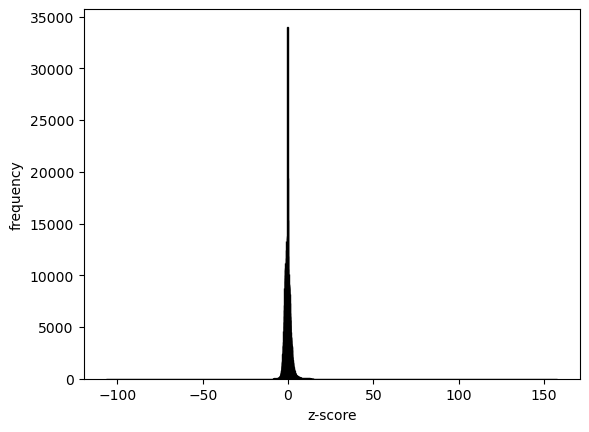

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
plt.hist(df['apex_zscore'], bins='auto', edgecolor='black')
plt.xlabel('z-score')
plt.ylabel('frequency')
plt.show()

# estimating variance with a negative binomial model

* `successes` is an array representing the number of successes (e.g., counts).
* `exposure` is an array representing an exposure variable (e.g., the number of trials or observations).
* the np.log(exposure) is used as an offset to model the log of the exposure variable.

The binomial answers the question "if I flip a coin n times, how many times will I get a heads?" It models any sort of yes-no counting process.

The negative binomial is the opposite of the binomial. It answers the question, "how many coin flips will it take for me to get x heads?"

In [44]:
import statsmodels.api as sm
import numpy as np

exposure = np.random.randint(5, 15, 100)
successes = np.random.randint(0, 5, 100)

# template
model = sm.GLM(successes, sm.add_constant(np.log(exposure)), family=sm.families.NegativeBinomial())
result = model.fit()

/stor/home/rmcox/miniconda3/envs/oligo/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [48]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -187.66
Date:                Sun, 21 Jan 2024   Deviance:                       57.081
Time:                        23:04:37   Pearson chi2:                     31.3
No. Iterations:                     5   Pseudo R-squ. (CS):          1.220e-05
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6818      0.830      0.821      0.412      -0.945       2.309
x1            -0.0136      0.378     -0.036      0.971      -0.754       0.727
==============================================================================
"""

In [110]:
df.reset_index(inplace=True, drop=True)
for i in range(0,99):
    node1 = df.node1[i]
    node2 = df.node2[i]
    print(f'{node1},{node2}')

AGAGAGAGA,GAGAGAGAG
ATATATATA,TATATATAT
GCGCGCGCG,CGCGCGCGC
TGTGAGAGG,GTGAGAGGG
GTGTGGTGG,TGTGGTGGG
TTGGAAGAT,TGGAAGATG
ATTGCGACT,TTGCGACTC
AAGGTAGGT,AGGTAGGTA
TAGGTGAGG,AGGTGAGGG
CTGGGTAGG,TGGGTAGGG
AGGTGCGAG,GGTGCGAGA
GTGTAAGGG,TGTAAGGGG
ATGTAGAGG,TGTAGAGGG
TGGGTAAGG,GGGTAAGGG
AAAAGTAGG,AAAGTAGGG
TGGGTCAAA,GGGTCAAAT
GTGATGTGG,TGATGTGGG
TGAGGTGTG,GAGGTGTGG
CATGTGGGT,ATGTGGGTT
ATGTGGGGT,TGTGGGGTA
AATGGTAGG,ATGGTAGGT
AAGGTAGGT,AGGTAGGTT
GTAGGTGGG,TAGGTGGGG
CATGTGAAG,ATGTGAAGA
CCGTAACGA,CGTAACGAT
GGAGGGCGG,GAGGGCGGA
AAGTGGTAG,AGTGGTAGG
AAGAGGTGG,AGAGGTGGG
CCACCTGTG,CACCTGTGT
TTGTGCCGG,TGTGCCGGG
TAAGGGACA,AAGGGACAG
GAGGTAGGG,AGGTAGGGA
ATGTCGGAT,TGTCGGATA
CCGCCCCTC,CGCCCCTCT
ATGATCCAG,TGATCCAGA
GTGAAGGTG,TGAAGGTGA
TCGTGGTAG,CGTGGTAGG
TTGGCTGTG,TGGCTGTGA
CAGACGAGT,AGACGAGTT
GCTGGACGA,CTGGACGAA
CAGGGAAAT,AGGGAAATG
AAACCGATG,AACCGATGG
CATTGGGGT,ATTGGGGTA
AAGGGGGGG,AGGGGGGGC
TGTGAGTAG,GTGAGTAGA
TGAAGTAGG,GAAGTAGGG
TGTACTGGG,GTACTGGGG
GTGGGGTAG,TGGGGTAGT
TGGCATGGG,GGCATGGGG
TAAATGGGG,AAATGGGGT


In [109]:
df

,node1,node2,exp_count,bg_count,exp,label,fc,log2fc
1995,AGAGAGAGA,GAGAGAGAG,4351,0,0w,no match,4618.279094,12.173140
52751,ATATATATA,TATATATAT,174,0,0w,no match,185.707454,7.536888
86570,GCGCGCGCG,CGCGCGCGC,118,0,0w,no match,126.281069,6.980495
308006,TGTGAGAGG,GTGAGAGGG,52,0,0w,no match,56.242829,5.813597
355467,GTGTGGTGG,TGTGGTGGG,47,0,0w,no match,50.936902,5.670639
...,...,...,...,...,...,...,...,...
1006200,ACCTGTCAG,CCTGTCAGA,0,42,0w,no match,-40.520721,-5.340588
1006199,AAGCCACGT,AGCCACGTG,0,43,0w,no match,-41.463064,-5.373755
1006198,CGCGCGCGC,GCGCGCGCG,0,142,0w,no match,-134.754957,-7.074195
1006197,TATATATAT,ATATATATA,0,173,0w,no match,-163.967570,-7.357267


In [87]:
df['zscore_trad'] = (df['exp_count'] - df['bg_count'].mean())/(df['bg_count'].std(ddof=1))
df[df.label == 'oligo match']

,node1,node2,exp_count,bg_count,exp,label,fc,log2fc,zscore_trad
943787,ATGGAGTGT,TGGAGTGTA,15,0,0w,oligo match,16.978967,4.085677,-0.010038
1002349,TGGATGGAG,GGATGGAGT,11,0,0w,oligo match,12.734225,3.670639,-0.010152
14308,GTTTTTTTT,TTTTTTTTT,562,349,0w,oligo match,1.706993,0.771457,0.005477
459473,TTCTGGATG,TCTGGATGG,39,28,0w,oligo match,1.463704,0.549624,-0.009358
31750,TGTTTTTTT,GTTTTTTTT,275,201,0w,oligo match,1.449937,0.535990,-0.002663
292744,AGCCTGTTT,GCCTGTTTT,53,42,0w,oligo match,1.332651,0.414300,-0.008961
59848,CTGTTTTTT,TGTTTTTTT,157,128,0w,oligo match,1.299747,0.378230,-0.006011
514268,ACCGGTTGT,CCGGTTGTG,36,30,0w,oligo match,1.266576,0.340934,-0.009443
880731,TGGAGTGTA,GGAGTGTAC,18,15,0w,oligo match,1.260158,0.333604,-0.009953
85133,GGTTGTGAG,GTTGTGAGC,120,106,0w,oligo match,1.200032,0.263073,-0.007060


In [54]:
df['zscore_apex'] = ([calc_apex_zscore(i, j, int(df['exp_count'].sum()), int(df['bg_count'].sum())) \
                      for i, j in zip(df.exp_count, df.bg_count)])


KeyboardInterrupt: 

# code archive below here

In [4]:
kmers = list(range(11,16))
kmers

[11, 12, 13, 14, 15]

In [5]:
# for k in kmers:
#     library_file = f'../oligo/data/bait_kmers/library_{k}mers.csv'
#     lib_set = get_library_set(library_file)
#     for i in range(1,4):
#         files = glob.glob(f'../oligo/results_pruned/{k}mer/oligo_{i}*{k}mers_unique.csv')
#         print(files)
#         truth_file = f'../oligo/data/bait_kmers/oligo_{i}_{k}mers.csv'
#         outfile_prefix = f'oligo_{i}'
#         for f in tqdm(files):
#             truth_set = get_truth_set(truth_file)
#             exp = re.search('(?<=_)\w\w(?=_)', f)[0]
#             df = calc_zscore(f)
#             df_out = label_exp(df, truth_set, lib_set, exp)
#             df_out.to_csv(f'../oligo/results_pruned/{k}mer/{outfile_prefix}_{exp}_{k}mer_enrichment.csv', index=False)

In [6]:
kmers = list(range(5,16))
kmers

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [7]:
for k in kmers:
    library_file = f'../oligo/data/bait_kmers/library_{k}mers.csv'
    lib_set = get_library_set(library_file)
    for i in range(1,4):
        files = glob.glob(f'../oligo/results_pruned/{k}mer/oligo_{i}*{k}mers_unique.csv')
        print(files)
        truth_file = f'../oligo/data/bait_kmers/oligo_{i}_comp_{k}mers.csv'
        outfile_prefix = f'oligo_{i}'
        for f in tqdm(files):
            truth_set = get_truth_set(truth_file)
            exp = re.search('(?<=_)\w\w(?=_)', f)[0]
            df = calc_zscore(f)
            df_out = label_exp(df, truth_set, lib_set, exp)
            df_out.to_csv(f'../oligo/results_pruned/{k}mer/{outfile_prefix}_{exp}_comp_{k}mer_enrichment.csv', index=False)

['../oligo/results_pruned/5mer/oligo_1_3w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_1_0w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_1_bg_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_1_1w_3mm_5mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.06it/s]


['../oligo/results_pruned/5mer/oligo_2_3w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_2_1w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_2_0w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_2_bg_3mm_5mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 51.12it/s]


['../oligo/results_pruned/5mer/oligo_3_1w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_3_0w_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_3_bg_3mm_5mers_unique.csv', '../oligo/results_pruned/5mer/oligo_3_3w_3mm_5mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 50.70it/s]


['../oligo/results_pruned/6mer/oligo_1_3w_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_1_1w_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_1_bg_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_1_0w_3mm_6mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.89it/s]


['../oligo/results_pruned/6mer/oligo_2_3w_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_2_bg_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_2_0w_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_2_1w_3mm_6mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.56it/s]


['../oligo/results_pruned/6mer/oligo_3_bg_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_3_0w_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_3_1w_3mm_6mers_unique.csv', '../oligo/results_pruned/6mer/oligo_3_3w_3mm_6mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.95it/s]


['../oligo/results_pruned/7mer/oligo_1_3w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_1_0w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_1_bg_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_1_1w_3mm_7mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


['../oligo/results_pruned/7mer/oligo_2_3w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_2_1w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_2_0w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_2_bg_3mm_7mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


['../oligo/results_pruned/7mer/oligo_3_1w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_3_0w_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_3_bg_3mm_7mers_unique.csv', '../oligo/results_pruned/7mer/oligo_3_3w_3mm_7mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


['../oligo/results_pruned/8mer/oligo_1_1w_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_1_0w_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_1_bg_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_1_3w_3mm_8mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


['../oligo/results_pruned/8mer/oligo_2_0w_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_2_bg_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_2_1w_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_2_3w_3mm_8mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


['../oligo/results_pruned/8mer/oligo_3_3w_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_3_0w_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_3_bg_3mm_8mers_unique.csv', '../oligo/results_pruned/8mer/oligo_3_1w_3mm_8mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


['../oligo/results_pruned/9mer/oligo_1_0w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_1_bg_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_1_1w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_1_3w_3mm_9mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]


['../oligo/results_pruned/9mer/oligo_2_1w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_2_0w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_2_bg_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_2_3w_3mm_9mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]


['../oligo/results_pruned/9mer/oligo_3_3w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_3_1w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_3_0w_3mm_9mers_unique.csv', '../oligo/results_pruned/9mer/oligo_3_bg_3mm_9mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]


['../oligo/results_pruned/10mer/oligo_1_3w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_1_0w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_1_1w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_1_bg_3mm_10mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.72s/it]


['../oligo/results_pruned/10mer/oligo_2_3w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_2_0w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_2_1w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_2_bg_3mm_10mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.64s/it]


['../oligo/results_pruned/10mer/oligo_3_3w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_3_0w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_3_1w_3mm_10mers_unique.csv', '../oligo/results_pruned/10mer/oligo_3_bg_3mm_10mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.71s/it]


['../oligo/results_pruned/11mer/oligo_1_3w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_1_1w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_1_0w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_1_bg_3mm_11mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:15<00:00, 18.84s/it]


['../oligo/results_pruned/11mer/oligo_2_3w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_2_1w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_2_0w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_2_bg_3mm_11mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.34s/it]


['../oligo/results_pruned/11mer/oligo_3_3w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_3_1w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_3_0w_3mm_11mers_unique.csv', '../oligo/results_pruned/11mer/oligo_3_bg_3mm_11mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:08<00:00, 17.11s/it]


['../oligo/results_pruned/12mer/oligo_1_bg_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_1_3w_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_1_0w_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_1_1w_3mm_12mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:37<00:00, 54.27s/it]


['../oligo/results_pruned/12mer/oligo_2_bg_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_2_3w_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_2_0w_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_2_1w_3mm_12mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:24<00:00, 36.08s/it]


['../oligo/results_pruned/12mer/oligo_3_bg_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_3_3w_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_3_0w_3mm_12mers_unique.csv', '../oligo/results_pruned/12mer/oligo_3_1w_3mm_12mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:45<00:00, 41.42s/it]


['../oligo/results_pruned/13mer/oligo_1_3w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_1_1w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_1_0w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_1_bg_3mm_13mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 95.80s/it]


['../oligo/results_pruned/13mer/oligo_2_3w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_2_1w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_2_0w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_2_bg_3mm_13mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:29<00:00, 52.49s/it]


['../oligo/results_pruned/13mer/oligo_3_3w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_3_1w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_3_0w_3mm_13mers_unique.csv', '../oligo/results_pruned/13mer/oligo_3_bg_3mm_13mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:20<00:00, 65.22s/it]


['../oligo/results_pruned/14mer/oligo_1_3w_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_1_0w_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_1_1w_3mm_14mers_unique.csv']


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:18<00:00, 126.15s/it]


['../oligo/results_pruned/14mer/oligo_2_bg_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_2_3w_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_2_0w_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_2_1w_3mm_14mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:16<00:00, 64.17s/it]


['../oligo/results_pruned/14mer/oligo_3_bg_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_3_3w_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_3_0w_3mm_14mers_unique.csv', '../oligo/results_pruned/14mer/oligo_3_1w_3mm_14mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:23<00:00, 80.98s/it]


['../oligo/results_pruned/15mer/oligo_1_0w_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_1_1w_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_1_3w_3mm_15mers_unique.csv']


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:24<00:00, 148.29s/it]


['../oligo/results_pruned/15mer/oligo_2_bg_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_2_0w_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_2_1w_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_2_3w_3mm_15mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:56<00:00, 74.01s/it]


['../oligo/results_pruned/15mer/oligo_3_bg_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_3_0w_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_3_1w_3mm_15mers_unique.csv', '../oligo/results_pruned/15mer/oligo_3_3w_3mm_15mers_unique.csv']


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:19<00:00, 94.99s/it]


In [8]:
# redo_files = ['../oligo/results/13mer/oligo_1_0w_13mers_unique.csv','../oligo/results/14mer/oligo_1_bg_14mers_unique.csv','../oligo/results/15mer/oligo_1_bg_15mers_unique.csv']
# redo_k = [13, 14, 15]
# i=1
# for k, f in zip(redo_k, redo_files):
#     print(k, '\t', f)
#     library_file = f'../oligo/data/bait_kmers/library_{k}mers.csv'
#     lib_set = get_library_set(library_file)
#     truth_file = f'../oligo/data/bait_kmers/oligo_{i}_{k}mers.csv'
#     outfile_prefix = f'oligo_{i}'
#     exp = re.search('(?<=_)\w\w(?=_)', f)[0]
#     df = calc_zscore(f)
#     df_out = label_exp(df, truth_set, lib_set, exp)
#     df_out.to_csv(f'../oligo/results/{k}mer/{outfile_prefix}_{exp}_{k}mer_enrichment.csv', index=False)

In [9]:
# k=11
# library_file = f'../oligo/data/bait_kmers/library_comp_{k}mers.csv'
# lib_set = get_library_set(library_file)

In [10]:
# for i in range(1,4):
#     files = glob.glob(f'../oligo/results/{k}mer/oligo_{i}*{k}mers_unique.csv')
#     print(files)
#     truth_file = f'../oligo/data/bait_kmers/oligo_{i}_{k}mers.csv'
#     outfile_prefix = f'oligo_{i}'
#     for f in tqdm(files):
#         truth_set = get_truth_set(truth_file)
#         exp = re.search('(?<=_)\w\w(?=_)', f)[0]
#         df = calc_zscore(f)
#         df_out = label_exp(df, truth_set, lib_set, exp)
#         #df_out.to_csv(f'../oligo/results/{k}mer/{outfile_prefix}_{exp}_{k}mer_enrichment.csv', index=False)

## streptavidin

In [4]:
kmers = list(range(5,16))
for k in kmers:
    library_file = f'../oligo/data/bait_kmers/library_{k}mers.csv'
    lib_set = get_library_set(library_file)
    files = glob.glob(f'../oligo/results/hfog1/streptavidin*_{k}mers_unique.csv')
    print(files)
    truth_file = f'../oligo/data/bait_kmers/oligo_all_comp_{k}mers.csv'
    outfile_prefix = f'streptavidin'
    for f in tqdm(files):
        truth_set = get_truth_set(truth_file)
        exp = re.search('(?<=_)\w\w(?=_)', f)[0]
        df = calc_zscore(f)
        df_out = label_exp(df, truth_set, lib_set, exp)
        df_out.to_csv(f'../oligo/results/{k}mer/{outfile_prefix}_{exp}_comp_{k}mer_enrichment.csv', index=False)

['../oligo/results/hfog1/streptavidin_bg_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_15mers_unique.csv']


100%|███████████████████████████████████████| 8/8 [05:49<00:00, 43.66s/it]


['../oligo/results/hfog1/streptavidin_7w_6mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_6mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_6mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_6mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:00<00:00,  5.34it/s]


['../oligo/results/hfog1/streptavidin_bg_7mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_7mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_7mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_7mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


['../oligo/results/hfog1/streptavidin_7w_8mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_8mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_8mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_8mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


['../oligo/results/hfog1/streptavidin_3w_9mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_9mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_9mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_9mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]


['../oligo/results/hfog1/streptavidin_3w_10mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_10mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_10mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_10mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:20<00:00,  5.08s/it]


['../oligo/results/hfog1/streptavidin_0w_11mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_11mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_11mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_11mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [01:10<00:00, 17.75s/it]


['../oligo/results/hfog1/streptavidin_bg_12mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_12mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_12mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_12mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [02:42<00:00, 40.65s/it]


['../oligo/results/hfog1/streptavidin_0w_13mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_13mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_13mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_13mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [04:13<00:00, 63.30s/it]


['../oligo/results/hfog1/streptavidin_0w_14mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_14mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_14mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_14mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [05:03<00:00, 75.96s/it]


['../oligo/results/hfog1/streptavidin_bg_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_15mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [05:48<00:00, 87.15s/it]


In [5]:
k = 5
library_file = f'../oligo/data/bait_kmers/library_{k}mers.csv'
lib_set = get_library_set(library_file)
files = glob.glob(f'../oligo/results/hfog1/streptavidin*_{k}mers_unique.csv')
print(files)
truth_file = f'../oligo/data/bait_kmers/oligo_all_comp_{k}mers.csv'
outfile_prefix = f'streptavidin'
for f in tqdm(files):
    truth_set = get_truth_set(truth_file)
    exp = re.search('(?<=_)\w\w(?=_)', f)[0]
    df = calc_zscore(f)
    df_out = label_exp(df, truth_set, lib_set, exp)
    df_out.to_csv(f'../oligo/results/{k}mer/{outfile_prefix}_{exp}_comp_{k}mer_enrichment.csv', index=False)

['../oligo/results/hfog1/streptavidin_bg_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_5mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]


In [6]:
kmers = list(range(5,16))
for k in kmers:
    library_file = f'../oligo/data/bait_kmers/library_{k}mers.csv'
    lib_set = get_library_set(library_file)
    files = glob.glob(f'../oligo/results/hfog1/streptavidin*_{k}mers_unique.csv')
    print(files)
    truth_file = f'../oligo/data/bait_kmers/oligo_all_{k}mers.csv'
    outfile_prefix = f'streptavidin'
    for f in tqdm(files):
        truth_set = get_truth_set(truth_file)
        exp = re.search('(?<=_)\w\w(?=_)', f)[0]
        df = calc_zscore(f)
        df_out = label_exp(df, truth_set, lib_set, exp)
        df_out.to_csv(f'../oligo/results/{k}mer/{outfile_prefix}_{exp}_{k}mer_enrichment.csv', index=False)

['../oligo/results/hfog1/streptavidin_bg_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_5mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_5mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 82.06it/s]


['../oligo/results/hfog1/streptavidin_7w_6mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_6mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_6mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_6mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 40.07it/s]


['../oligo/results/hfog1/streptavidin_bg_7mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_7mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_7mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_7mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


['../oligo/results/hfog1/streptavidin_7w_8mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_8mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_8mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_8mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


['../oligo/results/hfog1/streptavidin_3w_9mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_9mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_9mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_9mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]


['../oligo/results/hfog1/streptavidin_3w_10mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_10mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_10mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_10mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [00:19<00:00,  4.94s/it]


['../oligo/results/hfog1/streptavidin_0w_11mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_11mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_11mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_11mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [01:09<00:00, 17.35s/it]


['../oligo/results/hfog1/streptavidin_bg_12mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_12mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_12mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_12mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [02:40<00:00, 40.08s/it]


['../oligo/results/hfog1/streptavidin_0w_13mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_13mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_13mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_13mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [04:02<00:00, 60.71s/it]


['../oligo/results/hfog1/streptavidin_0w_14mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_14mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_14mers_unique.csv', '../oligo/results/hfog1/streptavidin_bg_14mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [05:02<00:00, 75.56s/it]


['../oligo/results/hfog1/streptavidin_bg_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_3w_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_7w_15mers_unique.csv', '../oligo/results/hfog1/streptavidin_0w_15mers_unique.csv']


100%|███████████████████████████████████████| 4/4 [05:47<00:00, 86.89s/it]
